In [6]:
import re
import time
import json
import pickle
import datetime

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [7]:
driver = webdriver.Chrome('chromedriver.exe')
driver.get('https://www.oddsportal.com/esports/results/')

C:\Users\royta\AppData\Local\Temp\ipykernel_18612\2489293918.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('chromedriver.exe')


In [8]:
def wait(className):
    max_wait_num = 4
    for _ in range(max_wait_num):
        try:
            myElem = WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.CLASS_NAME, className)))
            break
        except TimeoutException:
            if _ >= max_wait_num-1:
                return None

In [9]:
def scarp_games(time_point:int):
    games_links = []
    soup = BeautifulSoup(driver.page_source, 'html')
    table = soup.find('table', attrs={"id": 'tournamentTable'})
    for game in table.find_all('tr', class_ = "odd deactivate"):
        games_links.append(game.find('a').get('href'))

    next_page = soup.find('span', class_ = "arrow", text ='»')
    while next_page:
        time.sleep(1)
        driver.get(tournament + next_page.find_parent().get('href'))
        wait("col-content")

        soup = BeautifulSoup(driver.page_source, 'html')
        table = soup.find('table', attrs={"id": 'tournamentTable'})
        for game in table.find_all('tr', class_ = "odd deactivate"):
            games_links.append(game.find('a').get('href'))

        next_page = soup.find('span', class_ = "arrow", text ='»')
        link = next_page.find_parent().get('href')
        obj = re.search(r"#/page/\d+/", link)
        num1 = int(re.search(r"\d+", obj[0])[0])
        num2 = int(next_page.find_parent().get_attribute_list('x-page')[0])
        if num1 != num2:
            break
        
    games = []
    for link in games_links:
        try:
            driver.get(f"https://www.oddsportal.com{link}")
            wait("col-content")
            soup = BeautifulSoup(driver.page_source, 'html')
            working_space = soup.find("div", attrs = {"id":"col-content"})

            teams_names = working_space.find('h1').text
            date = working_space.find('p').text
            
            time_stamp = int(time.mktime(datetime.datetime.strptime(date, '%A, %d %b %Y, %H:%M').timetuple()))
            
            if time_stamp >= time_point:
                score = working_space.find("div", attrs = {"id":"event-status"}).find('p').find('strong').text
                odds = working_space.find("tr", class_="aver").find_all('td', class_="right")
                if len(odds) == 3:
                    t1_odd = working_space.find("tr", class_="aver").find_all('td', class_="right")[0].text
                    x_odd = working_space.find("tr", class_="aver").find_all('td', class_="right")[1].text
                    t2_odd = working_space.find("tr", class_="aver").find_all('td', class_="right")[2].text
                    games.append((teams_names, date, score, (t1_odd, x_odd, t2_odd), link))
                else:
                    t1_odd = working_space.find("tr", class_="aver").find_all('td', class_="right")[0].text
                    t2_odd = working_space.find("tr", class_="aver").find_all('td', class_="right")[1].text
                    games.append((teams_names, date, score, (t1_odd, t2_odd), link))
                
        except Exception as e:
            print(e)
            
        
    return games

In [10]:
with open('tournaments.json', "r") as j:
    tournaments = json.load(j)
    
games = []
months = 8
time_point = time.time() - 60*60*24*30*months
for tournament in tournaments:
    driver.get(tournament)
    wait("col-content")
    games += scarp_games(time_point)
    
    with open('odds.json', 'w') as f:
        json.dump(games, f)

'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
time data 'Yesterday, 13 Aug  2022, 21:00' does not match format '%A, %d %b %Y, %H:%M'
time data 'Yesterday, 13 Aug  2022, 15:00' does not match format '%A, %d %b %Y, %H:%M'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'
'NoneType' object has no attribute 'find'


In [15]:
import time
import json
import math
import pickle
import datetime
from contextlib import suppress

import sympy
import pandas as pd
import numpy as np

In [16]:
with open('output/out.json', 'r') as f:
    odds = json.load(f)
    
with open('output/myfile.json', 'r') as f:
    games = json.load(f)

In [18]:
for odd in odds:
    game = odd[0]
    


In [17]:
games[21]

[25, 6613691426, 5, 7407260]

In [2]:
val_df = pd.read_json('../parse/output/league/val_df.json')
test_df = pd.read_json('../parse/output/league/test_df.json')

df = pd.concat([val_df, test_df])
df['start_time'] = df['start_time'].astype('int64') // 10**9

In [3]:
# convert match win prob to map win prob

def bo2(P1, P2, M):
    P1 = (P1*(1+M))**(0.5)
    P2 = (P2*(1+M))**(0.5)
    return (1-0)/P1, (1-M)/P2


def bo3(P1, M):
    P1 = 1/(P1*(1+M))
    P2 = 1 - P1

    p1 = sympy.symbols('p1')
    p2 = 1 - p1
    group = (p1*p2*p1) + (p2*p1*p1) + (p1*p1) + (p1*p2*p2) + (p2*p1*p2) + (p2*p2)
    gfg_exp1 = (p1*p2*p1) + (p2*p1*p1) + (p1*p1) - P1*group

    intr = sympy.solve(gfg_exp1, dict=True)
    return (1-0)/(complex(intr[1][p1]).real)

def bo5(P1, M):    
    P1 = 1/(P1*(1+M))
    P2 = 1 - P1

    p1 = sympy.symbols('p1')
    p2 = 1 - p1
    group = p1*p1*p1+ p1*p1*p2*p1+ p1*p2*p1*p1+ p2*p1*p1*p1+ p2*p2*p1*p1*p1+ p1*p2*p2*p1*p1+ p1*p1*p2*p2*p1 +\
            p2*p2*p2+ p2*p2*p1*p2+ p2*p1*p2*p2+ p1*p2*p2*p2+ p1*p1*p2*p2*p2+ p2*p1*p1*p2*p2+ p2*p2*p1*p1*p2

    gfg_exp1 = (p1*p1*p1 + p1*p1*p2*p1 + p1*p2*p1*p1 + p2*p1*p1*p1 + p2*p2*p1*p1*p1 + p1*p2*p2*p1*p1 + p1*p1*p2*p2*p1) - P1*group

    intr = sympy.solve(gfg_exp1, dict=True)
    return (1-0)/(complex(intr[0][p1]).real)

In [4]:
def check_for_bo(g1, g2, cf_len):
    # we have 3 odds, so this is bo2
    if cf_len == 3:
        return 2
    
    elif (g1+g2)%2 == 1:
        max_ = max(g1, g2)
        if max_ == 3: return 5
        elif max_ == 2: return 3
        elif max_ == 1: return 1

In [5]:
how_many_games = 0
for game in games:
    try:
        g1 = int(game[2].split(":")[0])
        g2 = int(game[2].split(":")[1])
        how_many_games += (g1 + g2)
    except:pass

print(how_many_games)      

773


In [6]:
import requests

resp = requests.get("https://api.opendota.com/api/teams/").json()

names = {game['team_id']:game['name'] for game in resp}
tags = {game['team_id']:game['tag'] for game in resp}

In [7]:
replace_names = {
    'vgj.storm': ['vgj storm'],
    'tnc pro team': ['tnc predator'],
    'ig vitality': ['ig.vitality'],
    'vgj.thunder': ['vgj thunder'],
    'sg e-sports' : ['sg esports']
}

In [8]:
def func(x):
    resp = names.get(x)
    if resp:
        return resp.lower()
    else:
        return None
    
df['r_team_name'] = df['r_team_id'].apply(func)
df['d_team_name'] = df['d_team_id'].apply(func)

In [9]:
hours_minus = 24
hours_plus = 24

good_games = {"match_id": [], "r_odd": [], "d_odd": []}
bad_games = {"match_id": [], "r_odd": [], "d_odd": []}

broken_games_teams = []
broken_games_odds = []

for game in games:
    with suppress(Exception):
        teams = game[0]
        date = game[1]

        # ----------------------------------------- #
        g1, g2 = map(int, game[2].split(':'))
        team1, team2 = list(map(lambda x: x.strip().lower(), teams.split(' - ')))
        unix_time_start = int(time.mktime(datetime.datetime.strptime(date, '%A, %d %b %Y, %H:%M').timetuple()))

        odds = game[3]
        odds = list(map(float, odds))

        if max(odds) > 10:
            print("Extream odds")
            broken_games_odds.append(game)

        try: team1 = replace_names[team1]
        except: pass

        try: team2 = replace_names[team2]
        except: pass


        # ----------------------------------------- #
        # Found by time
        _df = df[['match_id', 'start_time', 'radiant_win', 'r_team_name', 'd_team_name', 'r_team_id', 'd_team_id']]
        time_match =  (_df['start_time'] > unix_time_start - 3600*hours_minus) & (_df['start_time'] < unix_time_start + 3600*hours_plus)

        if not len(_df[time_match]):
            print("Not matched by time")
            continue

        # Found by name
        names_arr = _df[time_match][['r_team_name', 'd_team_name']].values.astype('str')
        teams_match = ((names_arr[:, 0] == team1) & (names_arr[:, 1] == team2)) | ((names_arr[:, 0] == team2) & (names_arr[:, 1] == team1))

        if not teams_match.any():
            broken_games_teams.append([game, _df[time_match]])
            print("Not matched by names")
            continue

        if not (g1+g2) == len(_df[time_match][teams_match]):
            print("Not matched by num of games")
            continue

        # ----------------------------------------- #
        M = (1/odds[0] + 1/odds[1]) - 1

        bo = check_for_bo(g1, g2, len(odds))
        if bo == 2:
            odd1, odd2 = bo2(odds[0], odds[2], M)
        elif bo == 3:
            odd1 = bo3(odds[0], M)
            odd2 = bo3(odds[1], M)
        elif bo == 5:
            odd1 = bo5(odds[0], M)
            odd2 = bo5(odds[1], M)
        else:
            continue

        # ----------------------------------------- #
        idx = 0
        for match_id, b_ in zip(_df[time_match][teams_match]['match_id'].values, 
                                _df[time_match][teams_match]['r_team_name'].values == team1):
            if b_:
                odds = [odd1, odd2]
            else:
                odds = [odd2, odd1]


            if idx == 0:
                _games = good_games
            else:
                _games = bad_games


            _games['match_id'].append(match_id)
            _games['r_odd'].append(odds[0])
            _games['d_odd'].append(odds[1])

            idx+=1
            
_df = pd.concat([pd.DataFrame(good_games), pd.DataFrame(bad_games)], axis=0).reset_index()
_df.to_json("output/odds1.json")

Not matched by names
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by time
Not matched by

In [10]:
hours_minus = 24
hours_plus = 24

good_games = {"match_id": [], "r_odd": [], "d_odd": []}
bad_games = {"match_id": [], "r_odd": [], "d_odd": []}

broken_games_teams = []
broken_games_odds = []

out_df = pd.read_json("output/out.json")
for game, odds in zip(out_df['game'].values, out_df['odds'].values):
    if game['sport_id'] == '151':
        try:
            # ----------------------------------------- #
            g1, g2 = map(int, game["ss"].split('-'))
            team1, team2 = game['home']['name'].strip().lower(), game['away']['name'].strip().lower()
            unix_time_start = int(game['time'])

            odds = odds['Bet365']['odds']['start']['151_1']
            odds = [float(odds['home_od']), float(odds['away_od'])]
            if max(odds) > 10:
                print("Extream odds")
                broken_games_odds.append(game)

            # ----------------------------------------- #
            # Found by time
            _df = df[['match_id', 'start_time', 'radiant_win', 'r_team_name', 'd_team_name', 'r_team_id', 'd_team_id']]
            time_match =  (_df['start_time'] > unix_time_start - 3600*hours_minus) & (_df['start_time'] < unix_time_start + 3600*hours_plus)

            if not len(_df[time_match]):
                print("Not matched by time")
                continue

            # Found by name
            names_arr = _df[time_match][['r_team_name', 'd_team_name']].values.astype('str')
            teams_match = ((names_arr[:, 0] == team1) & (names_arr[:, 1] == team2)) | ((names_arr[:, 0] == team2) & (names_arr[:, 1] == team1))

            if not teams_match.any():
                broken_games_teams.append([game, _df[time_match]])
                print("Not matched by names")
                continue

            if not (g1+g2) == len(_df[time_match][teams_match]):
                print("Not matched by num of games")
                continue

            # ----------------------------------------- #
            M = (1/odds[0] + 1/odds[1]) - 1

            bo = check_for_bo(g1, g2, len(odds))
            if bo == 2:
                odd1, odd2 = bo2(odds[0], odds[2], M)
            elif bo == 3:
                odd1 = bo3(odds[0], M)
                odd2 = bo3(odds[1], M)
            elif bo == 5:
                odd1 = bo5(odds[0], M)
                odd2 = bo5(odds[1], M)
            else:
                continue

            # ----------------------------------------- #
            idx = 0
            for match_id, b_ in zip(_df[time_match][teams_match]['match_id'].values, 
                                    _df[time_match][teams_match]['r_team_name'].values == team1):
                if b_:
                    odds = [odd1, odd2]
                else:
                    odds = [odd2, odd1]


                if idx == 0:
                    _games = good_games
                else:
                    _games = bad_games


                _games['match_id'].append(match_id)
                _games['r_odd'].append(odds[0])
                _games['d_odd'].append(odds[1])

                idx+=1
                
        except Exception as e:
            print(e)
            
_df = pd.concat([pd.DataFrame(good_games), pd.DataFrame(bad_games)], axis=0).reset_index()
_df.to_json("output/odds2.json")

'NoneType' object is not subscriptable
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
'Bet365'
Not matched by time
Not matched by names
Not matched by names
Not matched by names
'Bet365'
Not matched by time
'Bet365'
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by num of games
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by num of games
Not matched by names
Not matched by names
Not matched by names
Not matched by names
Not matched by names
'NoneType' object has no attribute 'split'
Not matched by nam

#

In [1]:
import json
import time
import math
import datetime
from contextlib import suppress

import requests
import numpy as np
import pandas as pd
from lxml import html
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt; plt.style.use('seaborn')

In [2]:
resp = requests.get('https://hawk.live/matches/58642')
tree = html.fromstring(resp.content)
data_elems = tree.xpath('//*[@id="app"]')

if len(data_elems) > 1: raise Exception('Unexcepted html tree')

data = data_elems[0]
data = json.loads(dict(data.attrib)['data-page'])

In [3]:
is_team1_radiant = data['props']['match']['is_team1_radiant']
radiant_heroes = [hero['hero']['code_name'] for hero in data['props']['match']['picks'] if hero['is_radiant']]
dire_heroes = [hero['hero']['code_name'] for hero in data['props']['match']['picks'] if not hero['is_radiant']]

In [4]:
match_odds_info_array = {}
for odds in data['props']['match_odds_info_array']:
    _odds = []
    for odd in odds['odds']:
        with suppress(ValueError):
            
            if is_team1_radiant == True:
                if odds['is_team1_first'] == True:
                    radiant_odd = float(odd['first_team_winner'])
                    dire_odd = float(odd['second_team_winner'])
                    
                elif odds['is_team1_first'] == False:
                    radiant_odd = float(odd['second_team_winner'])
                    dire_odd = float(odd['first_team_winner'])
                else: raise
                
            elif is_team1_radiant == False:
                if odds['is_team1_first'] == True:
                    dire_odd = float(odd['first_team_winner'])
                    radiant_odd = float(odd['second_team_winner'])
                    
                elif odds['is_team1_first'] == False:
                    dire_odd = float(odd['second_team_winner'])
                    radiant_odd = float(odd['first_team_winner'])         
                else: raise
                
            else: raise
            
            created_at = int(time.mktime(datetime.datetime.strptime(odd['created_at'], '%Y-%m-%d %H:%M:%S').timetuple()))
            _odds.append({
                'r_odd': radiant_odd,
                'd_odd': dire_odd,
                'created_at': created_at
            })
            
    match_odds_info_array[odds['odds_provider_code_name']] = _odds

In [10]:
team1 = data['props']['match']['team1']['name']
team2 = data['props']['match']['team2']['name']

radiant_team = team1 if data['props']['match']['is_team1_radiant'] else team2
dire_team = team2 if data['props']['match']['is_team1_radiant'] else team1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


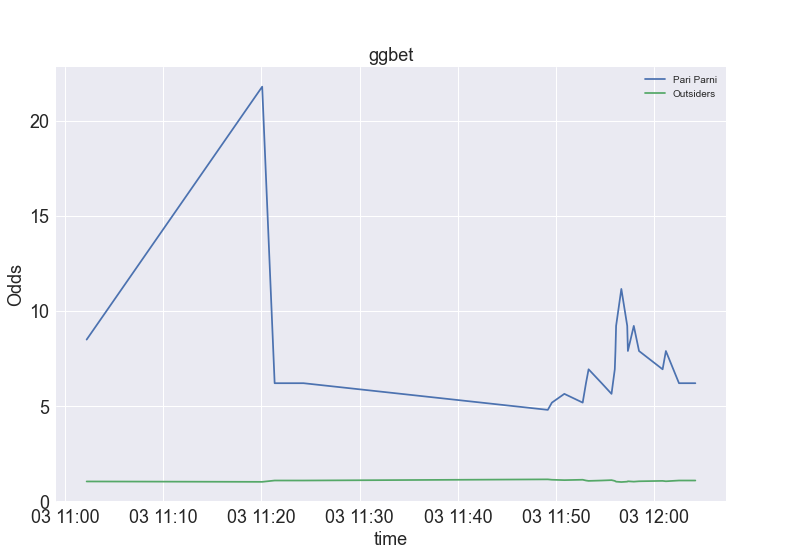

In [11]:
BOOK = 'ggbet'
font_size = 18

r_odds = [odd['r_odd'] for odd in match_odds_info_array[BOOK]]
d_odds = [odd['d_odd'] for odd in match_odds_info_array[BOOK]]
unix_time = [odd['created_at']+10800*2 for odd in match_odds_info_array[BOOK]]

df = pd.DataFrame({
    'r_odds': r_odds,
    'd_odds': d_odds,
    'time': unix_time
})
df['time'] = pd.to_datetime(df['time'], unit='s')


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(data=df, x='time', y='r_odds', ax=ax)
sns.lineplot(data=df, x='time', y='d_odds', ax=ax)
plt.title(BOOK)
plt.ylabel('Odds')
plt.legend([radiant_team, dire_team])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
    
fig.legend(fontsize=font_size)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


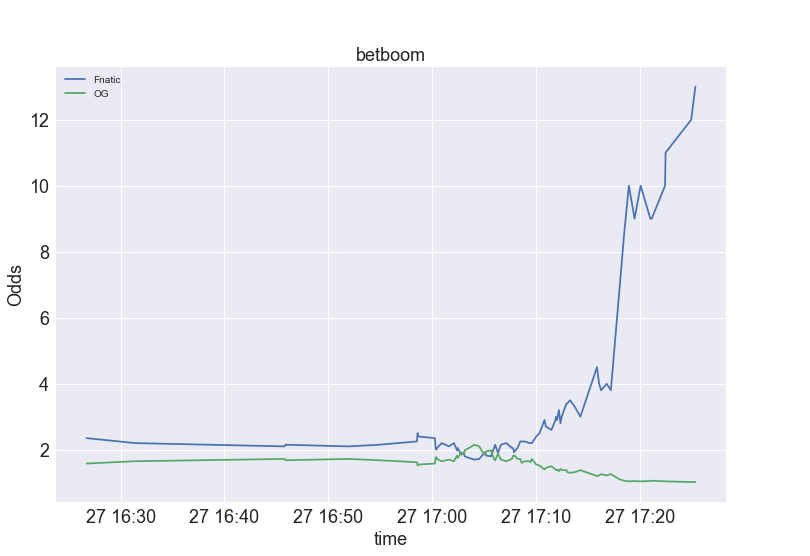

In [157]:
BOOK = 'betboom'
font_size = 18

r_odds = [odd['r_odd'] for odd in match_odds_info_array[BOOK]]
d_odds = [odd['d_odd'] for odd in match_odds_info_array[BOOK]]
unix_time = [odd['created_at']+10800*2 for odd in match_odds_info_array[BOOK]]

df = pd.DataFrame({
    'r_odds': r_odds,
    'd_odds': d_odds,
    'time': unix_time
})
df['time'] = pd.to_datetime(df['time'], unit='s')


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(data=df, x='time', y='r_odds', ax=ax)
sns.lineplot(data=df, x='time', y='d_odds', ax=ax)
plt.title(BOOK)
plt.ylabel('Odds')
plt.legend(['Fnatic', 'OG'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
    
fig.legend(fontsize=font_size)

In [18]:
import pymongo

In [19]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
table = client['Odds']["Test"]

In [35]:
_id = table.insert_one({'foo': 'bar'})

In [50]:
_id = table.find_one_and_replace(
    filter={'foo': 'bizz'}, 
    replacement={'foo': 'bar'},
    upsert=True,
)

In [51]:
_id

{'_id': ObjectId('630aaabeb3ab6da94a361fb7'), 'foo': 'bizz'}

In [49]:
str(_id.inserted_id)

AttributeError: 'NoneType' object has no attribute 'inserted_id'

In [9]:
fuzz.ratio("this is a test", "this is a test!")

97

In [17]:
fuzz.ratio("Team Spirit - OG", "TS - OG")

61

In [10]:
d

{'b': 2, 'c': 3}

In [11]:
max(d, key=d.get)

'c'

In [5]:
choices = ["Atlanta Falcons", "New York Jets", "New York Giants", "Dallas Cowboys"]
process.extract("new york jets", choices, limit=1)

[('New York Jets', 100)]